# classification models

train Perceptron model using **scikit-learn** API instead of creating API ourselves in the guide *simple-classification-algorithms*.

In [1]:
from sklearn import datasets
import numpy as np
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
print('class label:', np.unique(y))

class label: [0 1 2]


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def std_preprocessing(X, y, test_size=0.3, seed=1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=seed)
    ss = StandardScaler()
    X_train_std = ss.fit_transform(X_train)
    X_test_std = ss.transform(X_test)
    return X_train_std, X_test_std, y_train, y_test

In [3]:
X_train_std, X_test_std, y_train, y_test = std_preprocessing(X, y)

train Perceptron model. due to its OvR (one-versus-rest) algorithm, scikit-learn supports multiclass classification.

In [4]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score
ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)
y_pred = ppn.predict(X_test_std)
print('test accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred))
# print('test accuracy: %.3f' % ppn.score(X_test_std, y_test))

test accuracy: 0.978


In [5]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_boundary(X, y, classifier, step=0.02):
    markers = ("s", "x", "o", "^", "v")
    colors = ["red", "blue", "lightgreen", "gray", "cyan"]
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
    x2_min, x2_max = X[:, 1].min(), X[:, 1].max()
    # np.meshgrid returns coordinate matrices from coordinate vectors
    x1_coordinates, x2_coordinates = np.meshgrid(np.arange(x1_min - 1, x1_max + 1, step),
                                                 np.arange(x2_min - 1, x2_max + 1, step))
    # transpose an array using np.array.T
    Z = classifier.predict(np.array([x1_coordinates.ravel(), x2_coordinates.ravel()]).T)
    Z = Z.reshape(x1_coordinates.shape)
    plt.contourf(x1_coordinates, x2_coordinates, Z, alpha=0.3, cmap=cmap)
    plt.xlim(x1_coordinates.min(), x1_coordinates.max())
    plt.ylim(x2_coordinates.min(), x2_coordinates.max())

    for idx, cl in enumerate(np.unique(y)):
        # boolean masking
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=colors[idx], marker=markers[idx], label=cl)

visualize decision boundary of iris dataset carried out by scikit-learn Perceptron model.

In [6]:
def visualize_decision_boundary(X_train, y_train, classifier, X_test=None, y_test=None, xlabel="x", ylabel="y"):
    if X_test is not None and y_test is not None:
        fig = plt.figure(figsize=(10, 4))
    else:
        fig = plt.figure()
    fig.supxlabel(xlabel)
    fig.supylabel(ylabel)
    if X_test is None or y_test is None:
        plot_decision_boundary(X_train, y_train, classifier=classifier)
        plt.title("train")
        plt.legend(loc="best")
        
        plt.tight_layout()
        plt.show()
    else:
        plt.subplot(1, 2, 1)
        plot_decision_boundary(X_train, y_train, classifier=classifier)
        plt.title("train")
        plt.legend(loc="best")
        
        plt.subplot(1, 2, 2)
        plot_decision_boundary(X_test, y_test, classifier=classifier)
        plt.title("test")
        plt.legend(loc="best")
        
        plt.tight_layout()
        plt.show()

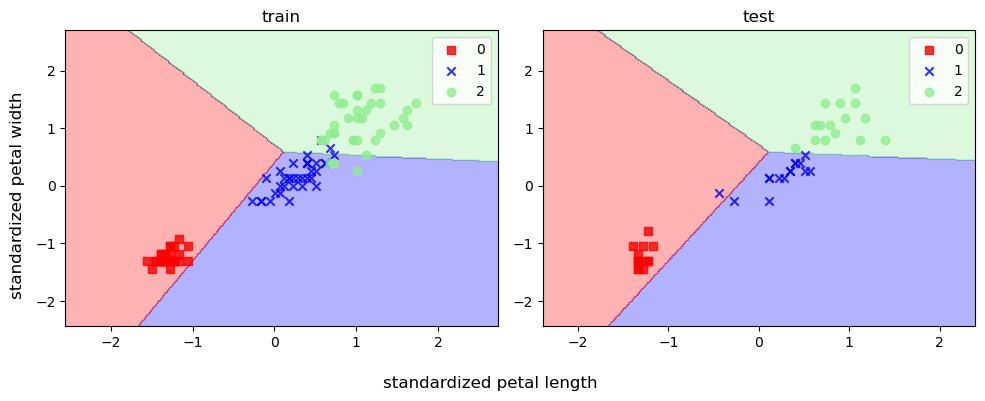

In [7]:
visualize_decision_boundary(X_train_std, y_train, classifier=ppn, \
                            X_test=X_test_std, y_test=y_test, \
                            xlabel="standardized petal length", ylabel="standardized petal width")

visualize how **sigmoid function** looks like and understand the concept of logistic regression.

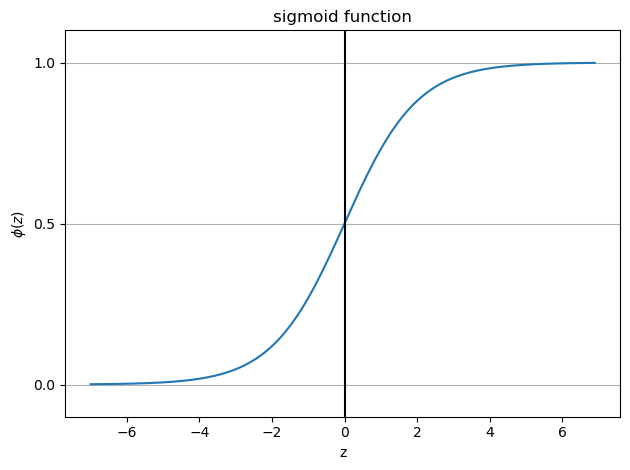

In [8]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)
plt.plot(z, phi_z)
plt.axvline(0.0, color="k")
plt.ylim((-0.1, 1.1))
plt.title("sigmoid function")
plt.xlabel("z")
plt.ylabel("$\phi (z)$")
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

visualize the **loss function** of the logistic regression. this indicates that if the output prediction is correct, there will be a zero cost (means no update on weights). However if it misses, there will be a huge penalization accordingly.

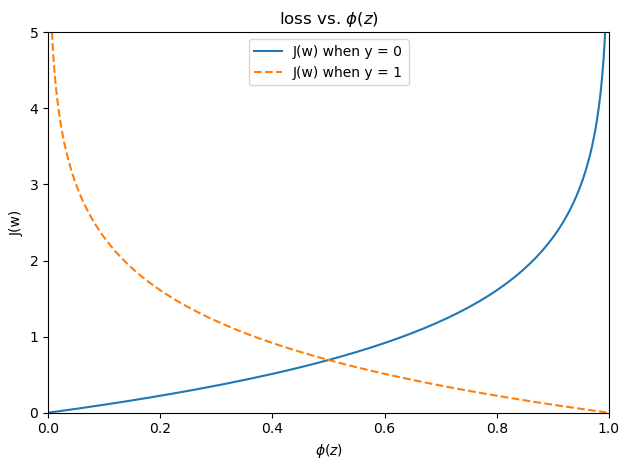

In [9]:
def loss_0(z):
    return -np.log(1-sigmoid(z))
def loss_1(z):
    return -np.log(sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)
l_0 = [loss_0(l) for l in z]
plt.plot(phi_z, l_0, label="J(w) when y = 0")
l_1 = [loss_1(l) for l in z]
plt.plot(phi_z, l_1, label="J(w) when y = 1", linestyle='--')
plt.xlim((0, 1))
plt.ylim((0, 5))
plt.title("loss vs. $\phi (z)$")
plt.xlabel("$\phi (z)$")
plt.ylabel("J(w)")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

create a **LogisticRegression** API.

In [10]:
class LogisticRegression(object):
    """
    lr: learning rate
    epochs: number of iterations
    random_state: seed
    """
    def __init__(self, lr=0.03, epochs=1000, random_state=1):
        self.lr = lr
        self.epochs = epochs
        self.random_state = random_state
    
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        w_size = 1 + X.shape[1]
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=w_size)
        self.cost_ = []
        for _ in range(self.epochs):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.lr * X.T.dot(errors)
            self.w_[0] += self.lr * errors.sum()
            cost = (-y.dot(np.log(output)) - (1-y).dot(np.log(1-output)))
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, z):
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, 0)

apply logistic regression model on the iris dataset (only binary classification is applicable here).

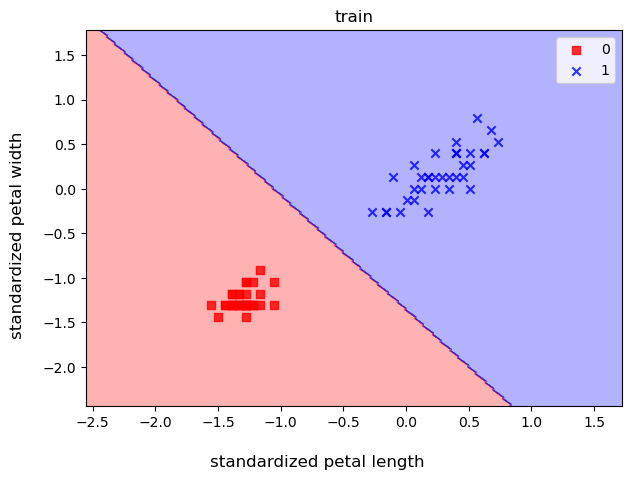

In [11]:
X_train_std_bi = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_bi = y_train[(y_train == 0) | (y_train == 1)]
logistic = LogisticRegression()
logistic.fit(X_train_std_bi, y_train_bi)
visualize_decision_boundary(X_train_std_bi, y_train_bi, classifier=logistic, \
                            xlabel="standardized petal length", ylabel="standardized petal width")

train logistic regression model using scikit-learn API.

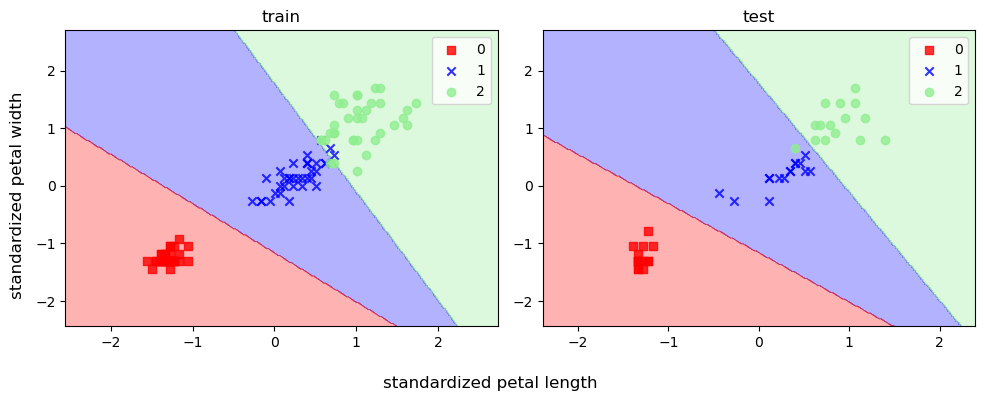

In [12]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100.0, random_state=1)
lr.fit(X_train_std, y_train)
visualize_decision_boundary(X_train_std, y_train, classifier=lr, \
                            X_test=X_test_std, y_test=y_test, \
                            xlabel="standardized petal length", ylabel="standardized petal width")

print out the test accuracy of logistic regression model on iris dataset.

In [13]:
print("test accuracy: %.3f" % lr.score(X_test_std, y_test))

test accuracy: 0.978


display the prediction of first 5 test samples. Then, using `argmax` function to return the class label of maximum value in each row. the index of the array corresponds to the class label of iris dataset.

In [14]:
lr.predict_proba(X_test_std[:5, :])

array([[1.52213484e-12, 3.85303417e-04, 9.99614697e-01],
       [9.93560717e-01, 6.43928295e-03, 1.14112016e-15],
       [9.98655228e-01, 1.34477208e-03, 1.76178271e-17],
       [3.79431985e-06, 9.04401285e-01, 9.55949212e-02],
       [5.22212406e-05, 9.94209099e-01, 5.73867966e-03]])

In [15]:
lr.predict_proba(X_test_std[:5, :]).argmax(axis=1)
# lr.predict(X_test_std[:5, :])

array([2, 0, 0, 1, 1], dtype=int64)

support vector machine (SVM) finds the maximum margin separating hyperplane. the margin in SVM is the distance from separating hyperplane to the closest sample in either class. those samples are called support vectors. the reason for finding large margin is that SVM with maximum margin tends to generalize better on the dataset whereas small margin will eventually make the model become ovefitting on the dataset.

Reference: https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote09.html

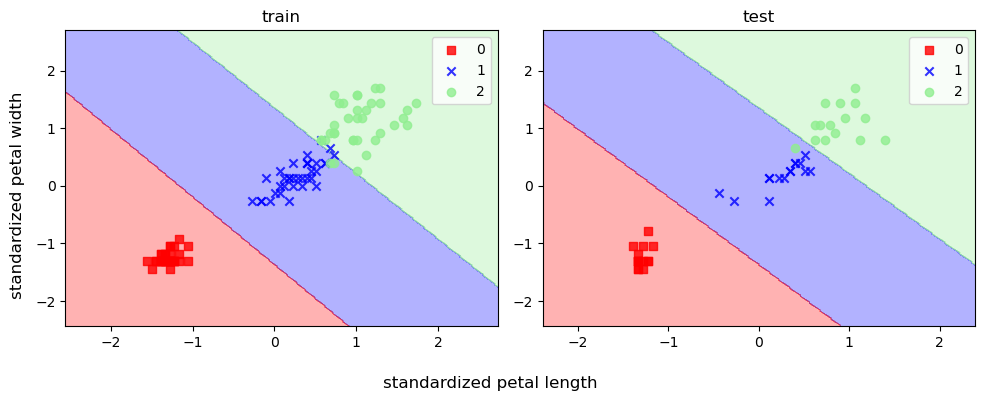

In [17]:
from sklearn.svm import SVC
svm = SVC(kernel="linear", C=1.0, random_state=1)
svm.fit(X_train_std, y_train)
visualize_decision_boundary(X_train_std, y_train, classifier=svm, \
                            X_test=X_test_std, y_test=y_test, \
                            xlabel="standardized petal length", ylabel="standardized petal width")

how about non-linear dataset that cannot find separating hyperplane (in 2D, hyperplane is a line) to classify each class? one of the reasons why SVM algorithm is well-used in a lot of industries is that it can also handle non-linear classification by using the **kernel trick**.

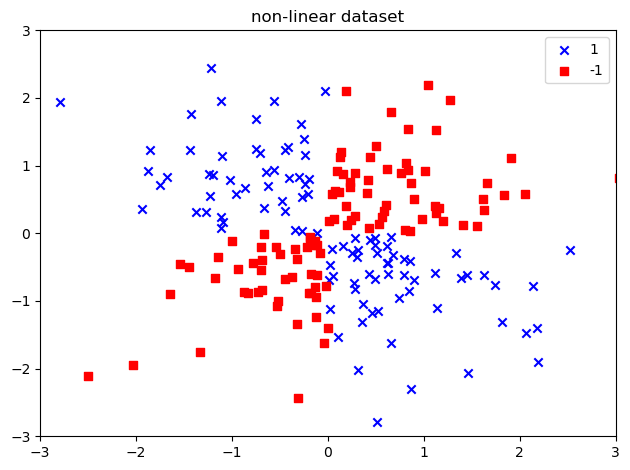

In [18]:
np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)
plt.scatter(X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1], c = "b", marker="x", label="1")
plt.scatter(X_xor[y_xor == -1, 0], X_xor[y_xor == -1, 1], c = "r", marker="s", label="-1")
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title("non-linear dataset")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

simply, we need to utilize mapping function $\phi$ to project non-linear dataset to the higher and transformable dimensional space. then in the higher dimentional space, those projected features can be linearly separated by using linear SVM model.

After obtaining a set of weights and decision boundary hyperplane through model training, just transform the dataset back to the original dimensional space using the same mapping function $\phi$. We can then use the model for non-linear classification.

However, the computation of mapping function $\phi$ (dot product of vectors) is extremely complicated and cost-consuming as the dimentional space gets higher and higher. Therefore, we use so-called a kernel trick, known as  kernel function **k**, to reduce the cost of dot product computation between two points in the higher dimensional space.

Refernce: https://stats.stackexchange.com/questions/152897/how-to-intuitively-explain-what-a-kernel-is & https://towardsdatascience.com/svm-and-kernel-svm-fed02bef1200

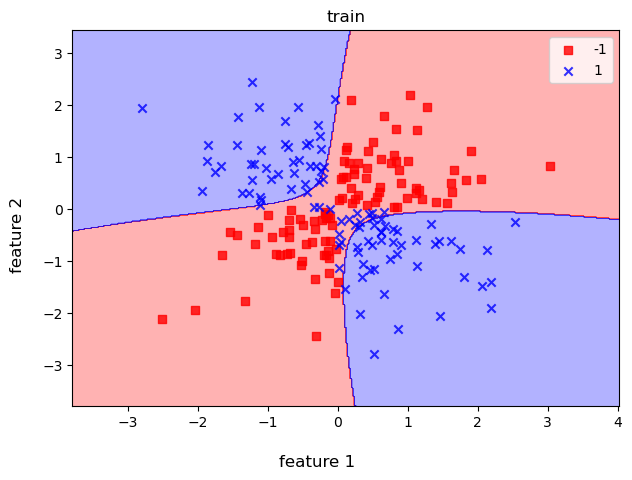

In [19]:
# RBF stands for Radial Basis Function, known as Gaussian kernel
svm = SVC(kernel='rbf', random_state=1, gamma=0.1, C=10.0) # gamma is a parameter for limiting the size of Gaussian sphere
svm.fit(X_xor, y_xor)
visualize_decision_boundary(X_xor, y_xor, classifier=svm, \
                            xlabel="feature 1", ylabel="feature 2")

perform kernel SVM model on the iris flower dataset.

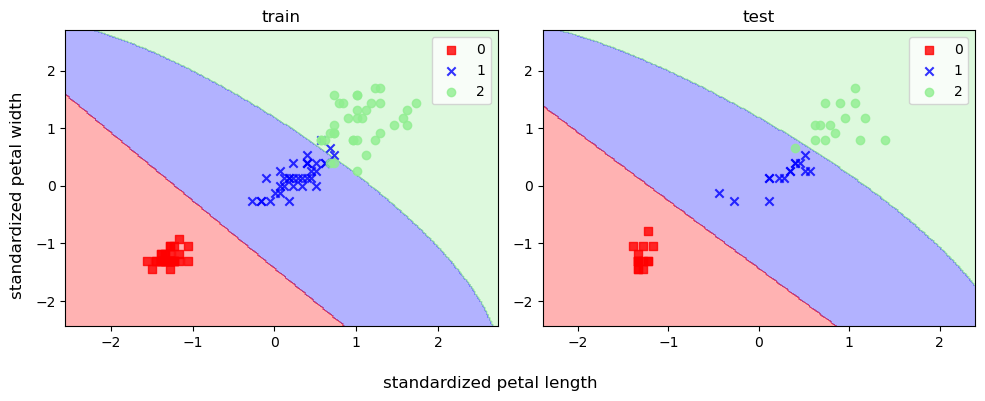

In [20]:
k_svm = SVC(kernel='rbf', random_state=1, gamma=0.1, C=10.0)
k_svm.fit(X_train_std, y_train)
visualize_decision_boundary(X_train_std, y_train, classifier=k_svm, \
                            X_test=X_test_std, y_test=y_test, \
                            xlabel="standardized petal length", ylabel="standardized petal width")

decision tree is a process of making decisions based on the given features to classify two or more class labels. the objective function of this algorithm is to decide which features to use in each node in order to maximize the **information gain**. 

the mathematical interpretation of information gain is defined as follows:

$IG(D_p, f) = I(D_p) - \sum_{j=1}^m {N_j \over N_p} I(D_j)$

where f is a feature, D_p and D_j are the dataset of parent and j-th child node respectively and I is an impurity.

there are three most commonly used impurity parameters known as **gini impurity**, **entropy** and **classification error**.

Reference: https://scikit-learn.org/stable/modules/tree.html

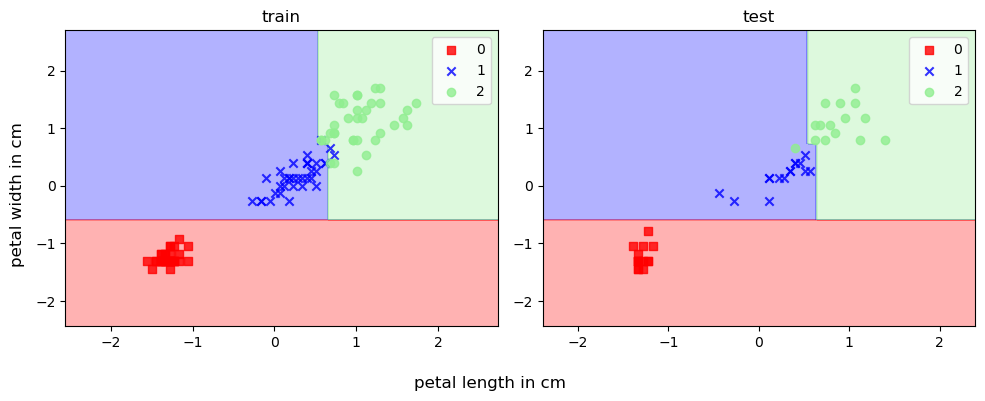

In [21]:
from sklearn.tree import DecisionTreeClassifier
# pruning the tree by setting the max depth of the tree equals to 4
tree_model = DecisionTreeClassifier(criterion="gini", max_depth=4, random_state=1) # use gini impurity
tree_model.fit(X_train_std, y_train)
visualize_decision_boundary(X_train_std, y_train, classifier=tree_model, \
                            X_test=X_test_std, y_test=y_test, \
                            xlabel="petal length in cm", ylabel="petal width in cm")

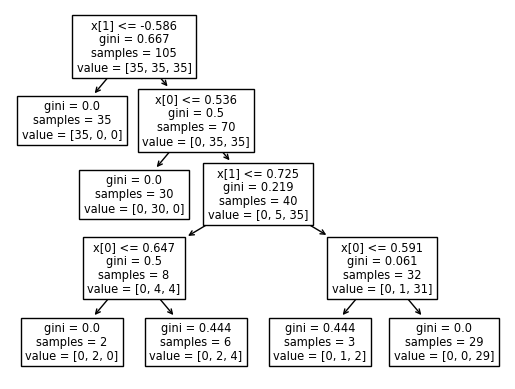

In [22]:
from sklearn import tree
tree.plot_tree(tree_model)
plt.show()

random forest is an **ensemble** of decision tree. the step-by-step guide of how random forest algorithm works is as follows:
1. take $n$ random bootstrap samples **with replacement**. $n$ is normally equal to the **number of samples**.
2. in each node, train the decision tree model using previously chosen bootstrap samples. 
    - 2.1 choose random $d$ features **without replacement**. $d$ is normally equal to the **square root of features**. 
    - 2.2 make decisions and divide the nodes based on the objective function decided. (e.g. maximize the information gain)
3. repeat previous steps $k$ times. $k$ is the only hyperparameter to choose in this algorithm.
4. make an average of all $k$ decision trees using majority voting and allocate class labels.

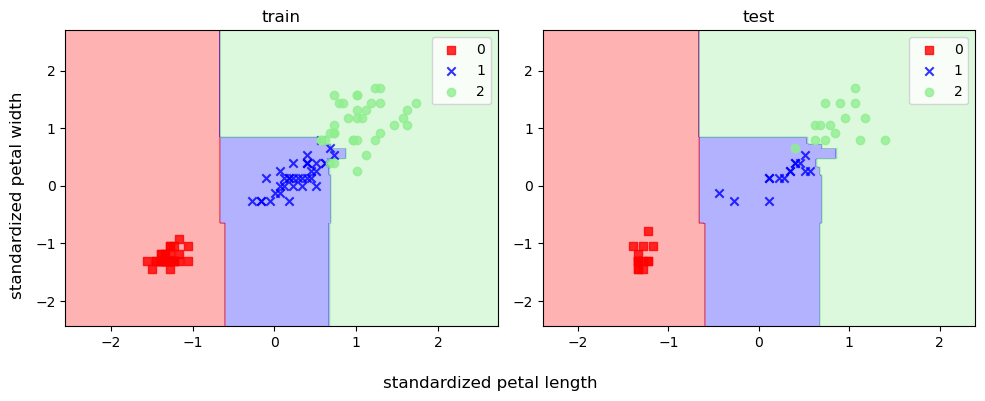

In [23]:
from sklearn.ensemble import RandomForestClassifier
# use 25 decision trees with gini impurity
forest = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, n_jobs=2)
forest.fit(X_train_std, y_train)
visualize_decision_boundary(X_train_std, y_train, classifier=forest, \
                            X_test=X_test_std, y_test=y_test, \
                            xlabel="standardized petal length", ylabel="standardized petal width")

unlike previous classification models seen before, the k-nearest neighbors (KNN) algorithm is a non-parametric and instance-based model where it stores all the training dataset instead of learning from it. therefore, a KNN algorithm does not require any computation resources. this kind of algorithm is typically referred to as a family of **lazy learning**.

a simple step-by-step guide of how KNN algorithm works is as follows:
1. determine the value $k$ and the distance metric.
2. find $k$ neighbors. the value $k$ is the number of neighbors around a specific query point to use to determine the class label of that point.
3. through majority voting, allocate the class labels of all samples.

Reference: https://www.ibm.com/topics/knn

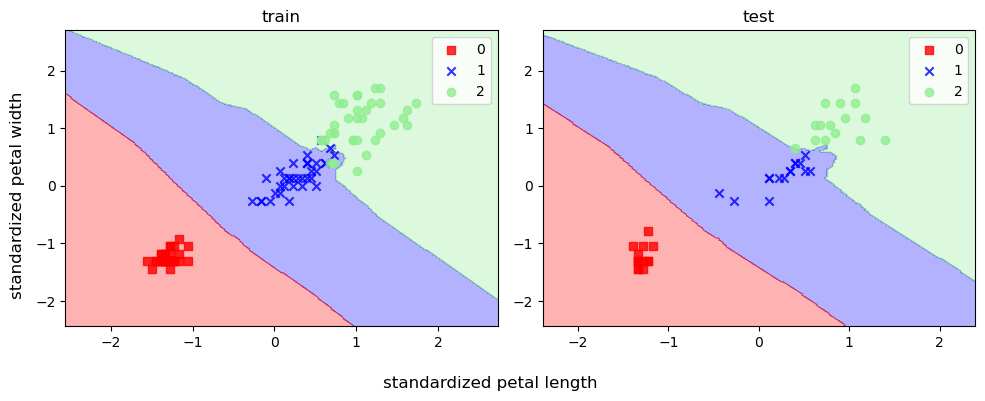

In [24]:
from sklearn.neighbors import KNeighborsClassifier
# minkowski distance is the generalized form of euclidean and manhattan distance metrics
# set p=2 to use euclidean distance, p=1 for manhattan distance
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)
visualize_decision_boundary(X_train_std, y_train, classifier=knn, \
                            X_test=X_test_std, y_test=y_test, \
                            xlabel="standardized petal length", ylabel="standardized petal width")

chapter 3 explore various classification models through scikit-learn API from the book Python Machine Learning 3rd Edition.
<br>
Summarized notes written by [Jihun (Jay) Han](https://github.com/hanjihun2000).